<h1><center>Análisis de Sistemas de Infraestructura <br>
    Tarea: Redes - Parte 1 Jupyter</center></h1>

Nota: Para realizar la tarea utilice el archivo Red Nacional(50 Nodos) con la siguiente información:

$\bullet$ Coordenadas de cada nodo

$\bullet$ Matriz de Conectividad

$\bullet$ Data Sub-red- link, TPD/año, Accidentes/año, Muertes/año, No. Interrupciones/año y Tiempo no-operación/año

In [1]:
# Primero importemos las librerías que usaremos en esta tarea. Recuerde que en caso de no tener instalada previamente alguna libreria necesitará instalarla con !pip install NombreDeLaLibreria

import networkx as nx  # Importar networkx
import matplotlib.pyplot as plt # importar librería de matplotlib
import matplotlib.colors as colors
from itertools import count
import geopy.distance 
import pandas as pd #Libreria para manejo de datos y estadistica
import numpy as np
from networkx.algorithms.connectivity import minimum_st_edge_cut
import math
import random
from sklearn.decomposition import PCA
%matplotlib inline
import time

G=nx.DiGraph()

<h2> 2. Recientemente se le entregó, en medio digital, un archivo digital con la red vial principal de
Colombia. Realice el siguiente análisis:<\h2>

<h3> Dibuje la red como es; y como un anillo. Qué puede observar sobre la red
antes de hacer un análisis?.<\h3>

In [2]:
nodos= pd.read_excel(r'Red_Vial(50 Nodos).xlsx') #Cargar coordanadas nodos
nodos.columns = ['Ciudad','Longitud','Latitud'] #Nombrar columnas
matrix_connect= pd.read_excel(r'Red_Vial(50 Nodos).xlsx',sheet_name = "Conectividad") # Cargar matriz de conectividad
matrix_connect.rename(columns={'Unnamed: 0': 'Ciudad'}, inplace=True) # Renombrar la columna 1 como ciudad
matrix_connect.set_index('Ciudad',inplace=True) # Indexar]
matrix_connect.fillna(0, inplace=True) # llenar las casillas vacías con cero
np.fill_diagonal(matrix_connect.values,0) # llenar diagonal con ceros

In [3]:
G = nx.from_numpy_array(matrix_connect.values, parallel_edges=True, create_using=nx.DiGraph()) #cargar los links a la red

# Proceso para renombrar los nodos con los nombres de las ciudades

dict1={} #Crea un diccionario 
i = 0

while i < 50:  #Hasta que se complete la cantidad de nodos   
    dict1[i] = nodos['Ciudad'].loc[i]
    i+=1
    
G = nx.relabel_nodes(G, dict1) #Nombra los nodos

#Cargar nodos

i = 0

while i < 50:
    G.add_node(nodos['Ciudad'].loc[i], pos=(nodos['Longitud'].loc[i], nodos['Latitud'].loc[i]))
    i+=1

Number of nodes 50
Number of edges 167
Average degree 6.68


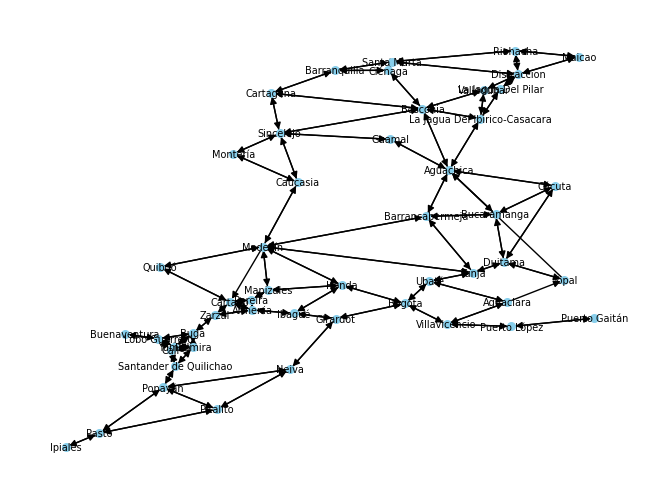

In [4]:
#Dibujamos la red
#print(nx.info(G)) #información de la red 
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))
nx.draw(G,nx.get_node_attributes(G, 'pos'), with_labels=True, font_size=7, node_color='skyblue', node_size=30) #dibujar la red normal
plt.savefig("networkxNormal1.png") #guardar en png la imagen 

Number of nodes 50
Number of edges 167
Average degree 6.68


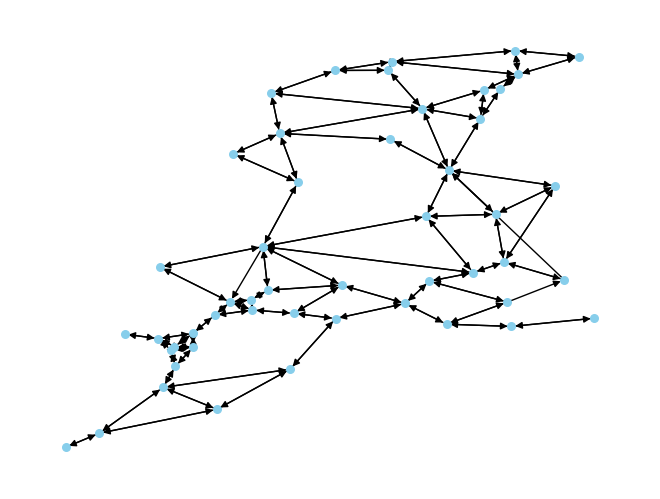

In [5]:
# Dibujo de la red sin etiquetas
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))
nx.draw(G,nx.get_node_attributes(G, 'pos'), with_labels=False, font_size=10, node_color='skyblue', node_size=30) #dibujar la red normal sin los nombres de las ciudades
#plt.savefig("networkxNormal2.png") #guardar en png la imagen 

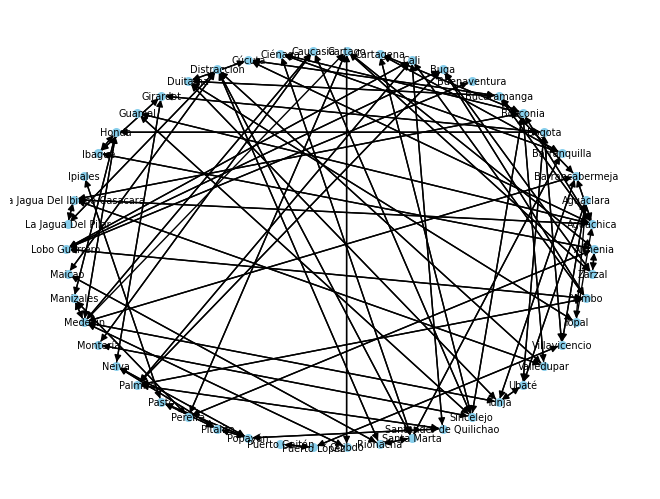

In [6]:
# Graficar como un anillo
nx.draw_circular(G, with_labels=True, font_size=7, node_color='skyblue', node_size=30)
plt.savefig("networkxAnillo.png") #guardar en png la imagen 

<h3>¿Cuáles son los 10 nodos con los mayores indices de centralidad (“degree”, “betweenness”,
matriz de rutas mínimas, cercanía (“closeness”))? compárelos entre sí, concluya, tiene sentido?(Statistics of a Node) <\h3>

In [7]:
# Cargar longitud como atributo de los enlaces

length=dict()
dict2=dict(G.edges)

def nodes_connected(u, v):
    
    return u in G.neighbors(v)

nodo_1=0
nodo_2=0
edge=0

for nodo_1 in range(0,50):
    for nodo_2 in range(0,50):
        ciudad_1=nodos['Ciudad'].loc[nodo_1]
        ciudad_2=nodos['Ciudad'].loc[nodo_2]
        condition=str(dict2.get((ciudad_1, ciudad_2),False))
        if condition=='False':
            continue
        else:
            coords_1 = (nodos['Latitud'].loc[nodo_1], nodos['Longitud'].loc[nodo_1]) 
            coords_2 = (nodos['Latitud'].loc[nodo_2], nodos['Longitud'].loc[nodo_2])
            G[ciudad_1][ciudad_2]['length']=geopy.distance.geodesic(coords_1, coords_2).km
            edge=edge+1

#G.edges(data=True)  #Verificar que entre los atributos se guardó length

In [8]:
# DEGREE --------------------------------------------------------------------

lista_degree=list(G.degree)
degree = pd.DataFrame(lista_degree)
degree.columns = ['Ciudad','Degree']
degree.set_index('Ciudad',inplace=True)
degree=degree.sort_values(by='Degree', ascending=False)
degree.head(n=10)

,Degree
Ciudad,
Medellín,13
Aguachica,13
Bosconia,12
Distraccion,10
Sincelejo,10
Cartago,9
Armenia,8
Yumbo,8
Tunja,8


In [9]:
# DEGREE CENTRALITY ------------------------------------------------------------

degree_c=nx.degree_centrality(G)
degree_c=pd.DataFrame.from_dict(degree_c, orient='index')
degree_c.columns = ['Degree Centrality']
degree_c=degree_c.sort_values(by='Degree Centrality', ascending=False)
degree_c.head(n=10)

,Degree Centrality
Medellín,0.265306
Aguachica,0.265306
Bosconia,0.244898
Distraccion,0.204082
Sincelejo,0.204082
Cartago,0.183673
Armenia,0.163265
Yumbo,0.163265
Tunja,0.163265
Santa Marta,0.163265


In [10]:
# BETWEENNESS --------------------------------------------------------------------

betwee=nx.betweenness_centrality(G,normalized=True, weight='length')
betw=pd.DataFrame.from_dict(betwee, orient='index')
betw.columns = ['Betweenness']
betw=betw.sort_values(by='Betweenness', ascending=False)
betw.head(n=10)

,Betweenness
Medellín,0.316327
Zarzal,0.294218
Aguachica,0.271684
Buga,0.271259
Bogota,0.256378
Barrancabermeja,0.249150
Cartago,0.238946
Girardot,0.178571
Manizales,0.173469
Tunja,0.169643


In [11]:
# MATRIZ DE RUTAS MINIMAS --------------------------------------------------------------
matriz_rutas_min=[]
nodo_1=0
nodo_2=0
edge=0
for nodo_1 in range(0,50):
    matriz_rutas_min.append([])
    for nodo_2 in range(0,50):
        ciudad_1=nodos['Ciudad'].loc[nodo_1]
        ciudad_2=nodos['Ciudad'].loc[nodo_2]
        matriz_rutas_min[nodo_1].append(nx.shortest_path_length(G,ciudad_1,ciudad_2,weight='length'))
        
matriz_rutas_min = pd.DataFrame(matriz_rutas_min) 
matriz_rutas_min
#matriz_rutas_min.to_excel("rm.xlsx") #Exportar a un archivo Excel

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,545.522347,368.478151,405.389387,760.044720,193.015523,719.786801,486.197613,191.750754,107.028910,...,830.197573,208.868821,539.428801,322.363544,265.196463,789.665785,271.462348,457.749891,151.765486,46.723529
1,545.522347,0.000000,484.014373,140.132960,368.906614,445.942455,186.624851,141.880546,708.132391,623.410547,...,333.953055,725.250458,243.948312,316.594434,373.761515,244.143438,524.389280,372.924509,668.147123,563.105165
2,368.478151,447.089627,0.000000,343.881413,815.996241,175.462628,633.714479,324.780126,560.228905,475.507061,...,781.042683,577.346972,691.037940,167.419940,110.252858,691.233065,97.015803,93.736163,520.243637,415.201679
3,405.389387,140.132960,343.881413,0.000000,509.039574,305.809495,326.757811,80.808226,567.999431,483.277587,...,474.086015,585.117498,384.081272,176.461474,233.628555,384.276398,384.256320,311.847820,528.014163,422.972205
4,760.044720,368.906614,852.920987,509.039574,0.000000,803.618879,182.281763,510.787160,922.654763,837.932919,...,70.152853,939.772831,220.615919,685.501048,742.668129,272.446945,882.065704,741.831123,882.669495,777.627538
5,193.015523,445.942455,175.462628,305.809495,803.618879,0.000000,632.567306,320.240994,384.766277,300.044433,...,779.895510,401.884345,583.002960,129.348021,72.180940,690.085892,78.446825,264.734367,344.781009,239.739052
6,719.786801,186.624851,670.639225,326.757811,182.281763,632.567306,0.000000,328.505397,882.396845,797.675001,...,147.328204,899.514912,180.358001,503.219285,560.386366,90.165182,711.014131,559.549360,842.411577,737.369619
7,486.197613,141.880546,358.312913,80.808226,510.787160,320.240994,328.505397,0.000000,648.807656,564.085812,...,475.833602,665.925724,385.828859,190.892973,248.060054,386.023984,398.687819,231.043963,608.822388,503.780431
8,191.750754,728.556734,560.228905,588.423774,943.079107,384.766277,902.821188,669.232000,0.000000,84.721844,...,1013.231960,127.867821,722.463187,514.114298,456.947217,972.700172,463.213102,649.500645,72.130011,145.027225
9,107.028910,643.834890,475.507061,503.701930,858.357263,300.044433,818.099344,584.510156,84.721844,0.000000,...,928.510116,101.839911,637.741344,429.392454,372.225373,887.978328,378.491258,564.778801,44.736576,60.305382


In [12]:
clos=nx.closeness_centrality(G) 
clos=pd.DataFrame.from_dict(clos, orient='index')
clos.columns = ['Closeness']
clos=clos.sort_values(by='Closeness', ascending=True)
clos.head(10)

,Closeness
Ipiales,0.135734
Maicao,0.144970
Puerto Gaitán,0.146707
Riohacha,0.146707
Buenaventura,0.155556
Pasto,0.156550
Santa Marta,0.167808
Distraccion,0.168385
Cali,0.170139
Puerto López,0.171329


<h3> Elabore un diagrama de Box-Plot en el que se visualice el “Degree” y el “Betweeness”.
Concluya <\h3>

Text(0.5, 1.0, 'Diagrama box-plot')

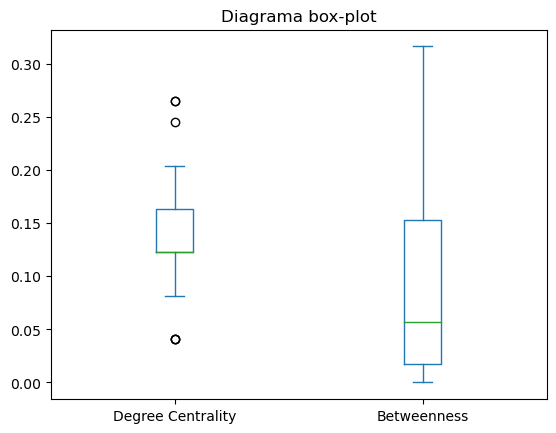

In [13]:
pd_degree_betweenness = pd.concat([degree_c, betw], axis=1) #concatenar en un dataFrame los datos de degree y betweenness
pd_degree_betweenness.plot(kind='box') #graficar el Box-Plot
plt.title('Diagrama box-plot')

In [14]:
#Algunas estadísticas utiles para concluir

Q3=pd_degree_betweenness.quantile(0.75) #Calculo del tercer cuartil
Q2=pd_degree_betweenness.quantile(0.5)
Q1=pd_degree_betweenness.quantile(0.25) #Calculo del primer cuartil
IQR=Q3-Q1 #Calculo del rango intercuartil
OUT_TU=Q3+1.5*IQR #Calculo del limite de outliers superior
OUT_TD=Q1-1.5*IQR #Calculo del limite de outliers inferior
OUT_INF=pd_degree_betweenness<OUT_TD #Para hallar los outliers inferiores
OUT_SUP=pd_degree_betweenness>OUT_TU #Para hallar los outliers superiores

<h3> Calcule los índices generales de la red -cuando sea posible- (e.g.1, “average degree or
degree distribution”)(Overall statistics) Analice y concluya<\h3>

In [15]:
#Indices generales de la red

st_degree=degree.describe() #estadisticas de degree
st_degree_c=degree_c.describe() #estadisticas de degree centrality
st_betw=betw.describe() #estadisticas de betweenness
st_clos=clos.describe() #estadisticas decloseness
st = pd.concat([st_degree,st_degree_c, st_betw,st_clos], axis=1) #concatenar estadisticas
st

,Degree,Degree Centrality,Betweenness,Closeness
count,50.000000,50.000000,50.000000,50.000000
mean,6.680000,0.136327,0.092007,0.210421
std,2.428067,0.049552,0.091573,0.038917
min,2.000000,0.040816,0.000000,0.135734
25%,6.000000,0.122449,0.017007,0.182326
50%,6.000000,0.122449,0.057185,0.211664
75%,8.000000,0.163265,0.152955,0.242276
max,13.000000,0.265306,0.316327,0.288235


Text(0.5, 1.0, 'Histograma de frecuencia relativa')

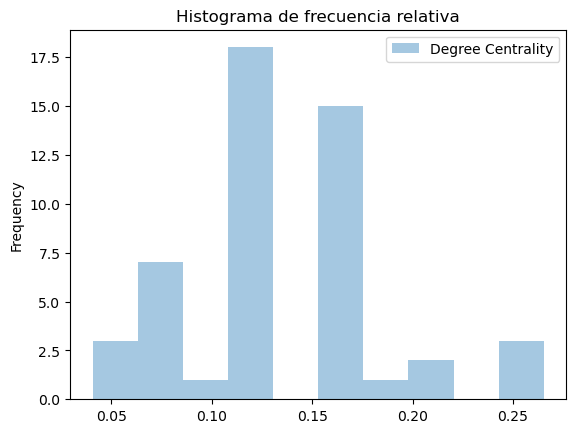

In [16]:
degree_c.plot.hist(alpha=0.4) # Histograma frecuencia relativa degree
plt.title('Histograma de frecuencia relativa')

Text(0.5, 1.0, 'Histograma de frecuencia relativa')

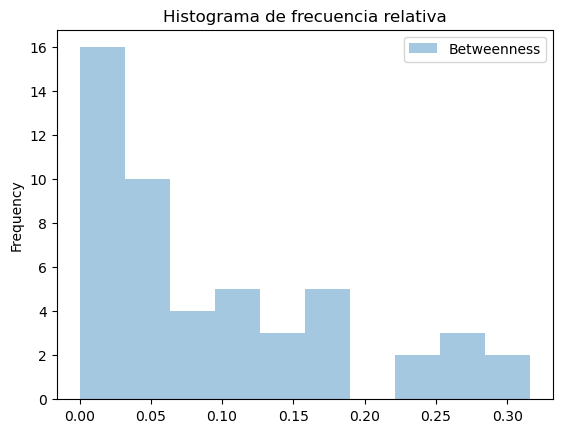

In [17]:
betw.plot.hist(alpha=0.4) # Histograma frecuencia relativa betweenness
plt.title('Histograma de frecuencia relativa')

<h3> Seleccione tres pares de nodos estratégicos (e.g., Bogotá y Buenaventura). Calcule la
confiabilidad de la conectividad entre ellos. Nota: utilice un valor de probabilidad de
falla estimada por unidad de longitud de λ = 0,001/km. <\h3>

In [18]:
print(nx.is_weakly_connected(G))

True


In [19]:
#Anadir a cada link la probabilidad de falla como atributo

nodo_1=0
nodo_2=0
edge=0

for nodo_1 in range(0,50):
    
    for nodo_2 in range(0,50):
        
        ciudad_1=nodos['Ciudad'].loc[nodo_1]
        ciudad_2=nodos['Ciudad'].loc[nodo_2]
        condition=str(dict2.get((ciudad_1, ciudad_2),False))
        
        if condition=='False':
            
            continue #G[ciudad_1][ciudad_2]['Pf']=0            
            
        else:
            G[ciudad_1][ciudad_2]['Pf']=0.001*G[ciudad_1][ciudad_2]['length']    
            
            print(ciudad_1,ciudad_2,0.001*G[ciudad_1][ciudad_2]['length'])

Armenia Cartago 0.035157959269556976
Armenia Ibagué 0.04910870413430617
Armenia Pereira 0.030313263046372368
Armenia Zarzal 0.04672352855480496
Aguachica Barrancabermeja 0.1401329600861288
Aguachica Bosconia 0.18662485117630145
Aguachica Bucaramanga 0.1418805463234282
Aguachica Cúcuta 0.13125106986416135
Aguachica Guamal 0.11478953832738195
Aguachica La Jagua Del Ibirico-Casacara 0.15892072809005753
Aguaclara Ubaté 0.11025285829502902
Aguaclara Villavicencio 0.09701580291065044
Aguaclara Yopal 0.09373616331260522
Barrancabermeja Aguachica 0.1401329600861288
Barrancabermeja Bucaramanga 0.08080822552353044
Barrancabermeja Medellín 0.2098070041752813
Barrancabermeja Tunja 0.17646147372218685
Barranquilla Cartagena 0.1000501125090842
Barranquilla Ciénaga 0.06098875626041812
Barranquilla Santa Marta 0.07015285332058506
Bogota Girardot 0.09274477460059925
Bogota Honda 0.09178751684424587
Bogota Ubaté 0.07218093978482083
Bogota Villavicencio 0.07844682487111351
Bosconia Aguachica 0.1866248511

In [20]:
# Confiabilidad de la conectividad entre dos nodos ----------------------------------------

#Definir el par de nodos (asegurese que minimum_st_edge_cut solo contenga un edge, esa es la estategia con la que se desarrollo el algoritmo)

Ciudad1='Bogota' 
Ciudad2='Buenaventura'

# Definir "minimal cut sets", quiero desconectar 2 de 1

min_cut_sets=list(minimum_st_edge_cut(G, Ciudad1 ,Ciudad2)) # Sentido ciudad 1 --> ciudad 2
print('Minimal edge-cut sets:', min_cut_sets)

# Calcular prob falla "minimal cut sets"

prob_falla=G[min_cut_sets[0][0]][min_cut_sets[0][1]]['Pf']

for i in range(0,50):
    for j in range(0,50):
        if (i,j) in list(G.edges) and i!=min_cut_sets[i][0] and j!=min_cut_sets[i][1]:
            prob_falla=prob_falla*(1-G[i][j]['Pf'])

print('La prob de falla es de:', round(prob_falla,4))

pf={}
pf[1]=prob_falla

Minimal edge-cut sets: [('Lobo Guerrero', 'Buenaventura')]
La prob de falla es de: 0.0416


In [21]:
# Combinatoria 

from itertools import combinations

cut_sets=[]
cut_sets.append(min_cut_sets)
cont=1
t=time.time()
G_copy = G.copy()

for n in range(2,4): #n esla longitud de los sets (si contienen 2 enlaces, 3 enlaces...)
    
    comb = list(combinations(list(G_copy.edges), n))
    comb2 =comb.copy()
    
    for j in range(0,len(cut_sets)):
        
        for v in range(0,len(comb)):
            
            if len(cut_sets[j])==1:
                
                if cut_sets[j][0] in comb[v]:
                    
                    comb2.remove(comb[v])
                    
        comb=comb2.copy()
        
    for i in range(0, len(comb)):
        
        G_copy.remove_edges_from(comb[i])
    
        if nx.has_path(G_copy,Ciudad1,Ciudad2) is False:
            
            cont=cont+1
            
            print('los arcos:',comb[i],'desconectan los nodos')
            
            cut_sets.append(list(comb[i]))
            prob_falla_aux=1
            
            for q in range(0, len(comb[i])):
                prob_falla_aux=prob_falla_aux*G[comb[i][q][0]][comb[i][q][1]]['Pf']
            
            for r in range(0,50):
                for w in range(0,50):
                    if (r,w) in list(G.edges):
                        if (r,w) not in comb[i]:
                            prob_falla_aux=prob_falla_aux*(1-G[list(G.nodes)[r]][list(G.nodes)[r]]['Pf'])
                            
            print('La prob de falla del set es: ',round(prob_falla_aux,5))              
            pf[cont]=pf[cont-1]+prob_falla_aux
            
        
        elapsed=time.time()-t #Tiempo transcurrido
        
        if cont>=3:  #Indique condicionales para cerrar el ciclo de acuero a lo que crea conveniente, dado que este metodo es exhaustivo y puede tardar demasiado
            break
            
        G_copy = G.copy()
    
    elapsed=time.time()-t 
    
    if cont>=3: #Indique condicionales para cerrar el ciclo de acuero a lo que crea conveniente, dado que este metodo es exhaustivo y puede tardar demasiado
        break
    
print(cut_sets)

los arcos: (('Girardot', 'Neiva'), ('Zarzal', 'Buga')) desconectan los nodos
La prob de falla del set es:  0.00968
los arcos: (('Popayán', 'Santander de Quilichao'), ('Zarzal', 'Buga')) desconectan los nodos
La prob de falla del set es:  0.00388
[[('Lobo Guerrero', 'Buenaventura')], [('Girardot', 'Neiva'), ('Zarzal', 'Buga')], [('Popayán', 'Santander de Quilichao'), ('Zarzal', 'Buga')]]


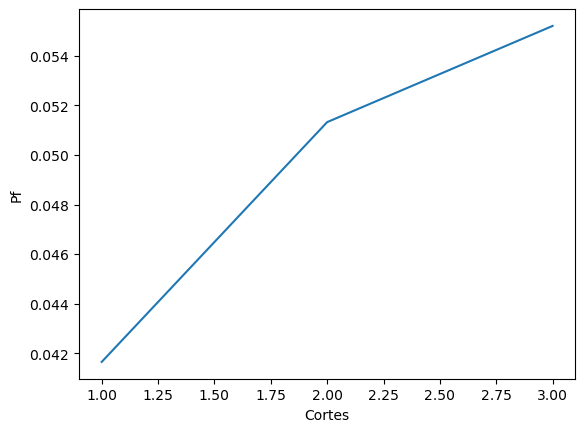

{1: 0.041646455188564274, 2: 0.05132749680278724, 3: 0.05521099295508878}


In [22]:
#Graficar
lists = sorted(pf.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.xlabel("Cortes")
plt.ylabel("Pf")
plt.show()
print(pf)

<h3> Elabore un diagrama en el que el tamaño -o el color- de los nodos dependa de su valor de
“Betweeness” (Figura 2). Concluya respecto a la distribución espacial de los nodos con
mayor “Betweeness”. <\h3>

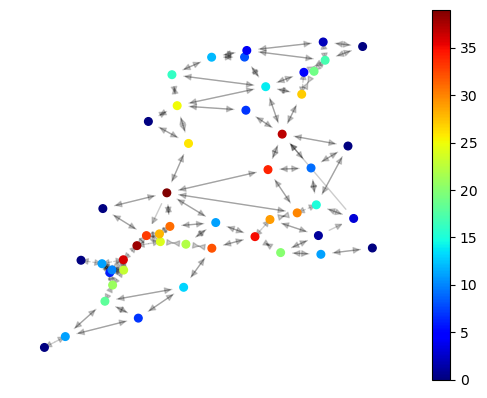

In [23]:
nx.set_node_attributes(G, betwee,'betweenness')

# obtener un grupo único 
groups = set(nx.get_node_attributes(G,'betweenness').values())
mapping = dict(zip(sorted(groups),count()))

nodes= G.nodes()
colors = [mapping[G.nodes[n]['betweenness']] for n in nodes]

#drawing nodes and edges separately so we can capture collection for colorbar
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), alpha=0.2)
nc = nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), nodelist=nodes, node_color=colors 
                            ,node_size=30, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [25]:
nx.get_edge_attributes(G,'length')

{('Armenia', 'Cartago'): 35.157959269556976,
 ('Armenia', 'Ibagué'): 49.10870413430617,
 ('Armenia', 'Pereira'): 30.313263046372366,
 ('Armenia', 'Zarzal'): 46.72352855480496,
 ('Aguachica', 'Barrancabermeja'): 140.1329600861288,
 ('Aguachica', 'Bosconia'): 186.62485117630146,
 ('Aguachica', 'Bucaramanga'): 141.8805463234282,
 ('Aguachica', 'Cúcuta'): 131.25106986416134,
 ('Aguachica', 'Guamal'): 114.78953832738195,
 ('Aguachica', 'La Jagua Del Ibirico-Casacara'): 158.92072809005754,
 ('Aguaclara', 'Ubaté'): 110.25285829502903,
 ('Aguaclara', 'Villavicencio'): 97.01580291065044,
 ('Aguaclara', 'Yopal'): 93.73616331260521,
 ('Barrancabermeja', 'Aguachica'): 140.1329600861288,
 ('Barrancabermeja', 'Bucaramanga'): 80.80822552353044,
 ('Barrancabermeja', 'Medellín'): 209.8070041752813,
 ('Barrancabermeja', 'Tunja'): 176.46147372218684,
 ('Barranquilla', 'Cartagena'): 100.0501125090842,
 ('Barranquilla', 'Ciénaga'): 60.98875626041812,
 ('Barranquilla', 'Santa Marta'): 70.15285332058505,
 ('